# Analysis of PPP Loans Originations by Community Banks and Non-Community Banks

# Imports

In [ ]:
from google.colab import auth, drive
auth.authenticate_user()

#Mount Drive
from google.colab import drive
drive.mount("/content/gdrive")

project_id = '<fill-me-in>'
bucket_name = '<fill-me-in>'

!gcloud config set project {project_id}
!gsutil -m cp -r  gs://{bucket_name}/ /content/drive/My\ Drive/data/ppp
%load_ext google.colab.data_table

# Pip install required libraries 
!pip install linearmodels
!pip install statsmodels

# Import main dependencies
import datetime
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from linearmodels.panel import PanelOLS, PooledOLS
from sklearn import linear_model
from zipfile import ZipFile
import statsmodels.api as sm 
import statsmodels.stats.api as sms

Mounted at /content/gdrive
Updated property [core/project].
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the cp command.
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the cp command.
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the cp command.
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the cp command.
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the cp command.
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the cp command.
CommandException: Destination URL must name a directory, bucket, or bucket
subdirectory for the multiple source form of the 

# Data Onboarding

## 2020

In [ ]:
'12/31/2020'
fdic_assets_lib_20201231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20201231.zip').open('All_Reports_20201231_Assets and Liabilities.csv'))
fdic_ppp_20201231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20201231.zip').open('All_Reports_20201231_(New) PPP Loans, PPLF Borrowings, and MMLF Assets.csv'))
fdic_performance_condition_20201231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20201231.zip').open('All_Reports_20201231_Performance and Condition Ratios.csv'))
fdic_demographics_20201231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20201231.zip').open('All_Reports_20201231_Memoranda.csv'))
fdic_loans_20201231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20201231.zip').open('All_Reports_20201231_Net Loans and Leases.csv'))
fdic_12312020_asset_ppp_merged = pd.merge(fdic_assets_lib_20201231,fdic_ppp_20201231[['cert','ppplnnum','ppplnbal','ppplnplg','ppplf1ls','ppplfov1','avpppplg','mmlfbal','avmmlf']],on='cert', how='left')
fdic_12312020_performance_merged = pd.merge(fdic_12312020_asset_ppp_merged, fdic_performance_condition_20201231[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_12312020_demgraphics_merged = pd.merge(fdic_12312020_performance_merged, fdic_demographics_20201231[['estymd','cert']] , on='cert',how="left")
fdic_12312020_final_merged = pd.merge(fdic_12312020_demgraphics_merged, fdic_loans_20201231[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_12312020_final_merged["quarter"] = int(4)
fdic_12312020_final_merged = fdic_12312020_final_merged.loc[:,~fdic_12312020_final_merged.columns.duplicated()]

'09/31/2020'
fdic_assets_lib_20200930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200930.zip').open('All_Reports_20200930_Assets and Liabilities.csv'))
fdic_ppp_20200930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200930.zip').open('All_Reports_20200930_(New) PPP Loans, PPLF Borrowings, and MMLF Assets.csv'))
fdic_performance_condition_20200930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200930.zip').open('All_Reports_20200930_Performance and Condition Ratios.csv'))
fdic_demographics_20200930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200930.zip').open('All_Reports_20200930_Memoranda.csv'))
fdic_loans_20200930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200930.zip').open('All_Reports_20200930_Net Loans and Leases.csv'))
fdic_20200930_asset_ppp_merged = pd.merge(fdic_assets_lib_20200930,fdic_ppp_20200930[['cert','ppplnnum','ppplnbal','ppplnplg','ppplf1ls','ppplfov1','avpppplg','mmlfbal','avmmlf']],on='cert', how='left')
fdic_20200930_performance_merged = pd.merge(fdic_20200930_asset_ppp_merged, fdic_performance_condition_20200930[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20200930_demgraphics_merged = pd.merge(fdic_20200930_performance_merged, fdic_demographics_20200930[['estymd','cert']] , on='cert',how="left")
fdic_20200930_final_merged = pd.merge(fdic_20200930_demgraphics_merged, fdic_loans_20200930[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20200930_final_merged["quarter"] = int(3)
fdic_20200930_final_merged = fdic_20200930_final_merged.loc[:,~fdic_20200930_final_merged.columns.duplicated()]

'06/31/2020'
fdic_assets_lib_20200630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200630.zip').open('All_Reports_20200630_Assets and Liabilities.csv'))
fdic_ppp_20200630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200630.zip').open('All_Reports_20200630_(New) PPP Loans, PPLF Borrowings, and MMLF Assets.csv'))
fdic_performance_condition_20200630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200630.zip').open('All_Reports_20200630_Performance and Condition Ratios.csv'))
fdic_demographics_20200630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200630.zip').open('All_Reports_20200630_Memoranda.csv'))
fdic_loans_20200630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200630.zip').open('All_Reports_20200630_Net Loans and Leases.csv'))
fdic_20200630_asset_ppp_merged = pd.merge(fdic_assets_lib_20200630,fdic_ppp_20200630[['cert','ppplnnum','ppplnbal','ppplnplg','ppplf1ls','ppplfov1','avpppplg','mmlfbal','avmmlf']],on='cert', how='left')
fdic_20200630_performance_merged = pd.merge(fdic_20200630_asset_ppp_merged, fdic_performance_condition_20200630[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20200630_demgraphics_merged = pd.merge(fdic_20200630_performance_merged, fdic_demographics_20200630[['estymd','cert']] , on='cert',how="left")
fdic_20200630_final_merged = pd.merge(fdic_20200630_demgraphics_merged, fdic_loans_20200630[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20200630_final_merged["quarter"] = int(2)
fdic_20200630_final_merged = fdic_20200630_final_merged.loc[:,~fdic_20200630_final_merged.columns.duplicated()]

'03/31/2020'
fdic_assets_lib_20200331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200331.zip').open('All_Reports_20200331_Assets and Liabilities.csv'))
fdic_performance_condition_20200331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200331.zip').open('All_Reports_20200331_Performance and Condition Ratios.csv'))
fdic_demographics_20200331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200331.zip').open('All_Reports_20200331_Memoranda.csv'))
fdic_loans_20200331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20200331.zip').open('All_Reports_20200331_Net Loans and Leases.csv'))
fdic_20200331_performance_merged = pd.merge(fdic_assets_lib_20200331, fdic_performance_condition_20200331[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20200331_demgraphics_merged = pd.merge(fdic_20200331_performance_merged, fdic_demographics_20200331[['estymd','cert']] , on='cert',how="left")
fdic_20200331_final_merged = pd.merge(fdic_20200331_demgraphics_merged, fdic_loans_20200331[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20200331_final_merged["quarter"] = int(1)
fdic_20200331_final_merged['ppplnnum']=0.0
fdic_20200331_final_merged['ppplnbal']=0.0
fdic_20200331_final_merged['ppplnplg']=0.0
fdic_20200331_final_merged['ppplf1ls']=0.0
fdic_20200331_final_merged['ppplfov1']=0.0
fdic_20200331_final_merged['avpppplg']=0.0
fdic_20200331_final_merged['mmlfbal']=0.0
fdic_20200331_final_merged['avmmlf']=0.0
fdic_20200331_final_merged = fdic_20200331_final_merged.loc[:,~fdic_20200331_final_merged.columns.duplicated()]

frames = [fdic_12312020_final_merged, fdic_20200930_final_merged, fdic_20200630_final_merged,fdic_20200331_final_merged]
fdic_2020_final_merged = pd.concat(frames)
fdic_2020_final_merged["year"] = int(2020)

fdic_2020_final_merged.to_csv(r'fdic_2020_final_merged.csv')
!cp fdic_2020_final_merged.csv "/content/gdrive/My Drive/data/comm_bank/"


## 2019

In [ ]:
'12/31/2019'
fdic_assets_lib_20191231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20191231.zip').open('All_Reports_20191231_Assets and Liabilities.csv'))
fdic_performance_condition_20191231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20191231.zip').open('All_Reports_20191231_Performance and Condition Ratios.csv'))
fdic_demographics_20191231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20191231.zip').open('All_Reports_20191231_Memoranda.csv'))
fdic_loans_20191231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20191231.zip').open('All_Reports_20191231_Net Loans and Leases.csv'))
fdic_12312019_performance_merged = pd.merge(fdic_assets_lib_20191231, fdic_performance_condition_20191231[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_12312019_demgraphics_merged = pd.merge(fdic_12312019_performance_merged, fdic_demographics_20191231[['estymd','cert']] , on='cert',how="left")
fdic_12312019_final_merged = pd.merge(fdic_12312019_demgraphics_merged, fdic_loans_20191231[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_12312019_final_merged["quarter"] = int(4)
fdic_12312019_final_merged = fdic_12312019_final_merged.loc[:,~fdic_12312019_final_merged.columns.duplicated()]

'09/31/2019'
fdic_assets_lib_20190930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190930.zip').open('All_Reports_20190930_Assets and Liabilities.csv'))
fdic_performance_condition_20190930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190930.zip').open('All_Reports_20190930_Performance and Condition Ratios.csv'))
fdic_demographics_20190930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190930.zip').open('All_Reports_20190930_Memoranda.csv'))
fdic_loans_20190930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190930.zip').open('All_Reports_20190930_Net Loans and Leases.csv'))
fdic_20190930_performance_merged = pd.merge(fdic_assets_lib_20190930, fdic_performance_condition_20190930[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20190930_demgraphics_merged = pd.merge(fdic_20190930_performance_merged, fdic_demographics_20190930[['estymd','cert']] , on='cert',how="left")
fdic_20190930_final_merged = pd.merge(fdic_20190930_demgraphics_merged, fdic_loans_20190930[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20190930_final_merged["quarter"] = int(3)
fdic_20190930_final_merged = fdic_20190930_final_merged.loc[:,~fdic_20190930_final_merged.columns.duplicated()]

'06/31/2019'
fdic_assets_lib_20190630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190630.zip').open('All_Reports_20190630_Assets and Liabilities.csv'))
fdic_performance_condition_20190630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190630.zip').open('All_Reports_20190630_Performance and Condition Ratios.csv'))
fdic_demographics_20190630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190630.zip').open('All_Reports_20190630_Memoranda.csv'))
fdic_loans_20190630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190630.zip').open('All_Reports_20190630_Net Loans and Leases.csv'))
fdic_20190630_performance_merged = pd.merge(fdic_assets_lib_20190630, fdic_performance_condition_20190630[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20190630_demgraphics_merged = pd.merge(fdic_20190630_performance_merged, fdic_demographics_20190630[['estymd','cert']] , on='cert',how="left")
fdic_20190630_final_merged = pd.merge(fdic_20190630_demgraphics_merged, fdic_loans_20190630[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20190630_final_merged["quarter"] = int(2)
fdic_20190630_final_merged = fdic_20190630_final_merged.loc[:,~fdic_20190630_final_merged.columns.duplicated()]

'03/31/2019'
fdic_assets_lib_20190331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190331.zip').open('All_Reports_20190331_Assets and Liabilities.csv'))
fdic_performance_condition_20190331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190331.zip').open('All_Reports_20190331_Performance and Condition Ratios.csv'))
fdic_demographics_20190331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190331.zip').open('All_Reports_20190331_Memoranda.csv'))
fdic_loans_20190331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20190331.zip').open('All_Reports_20190331_Net Loans and Leases.csv'))
fdic_20190331_performance_merged = pd.merge(fdic_assets_lib_20190331, fdic_performance_condition_20190331[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20190331_demgraphics_merged = pd.merge(fdic_20190331_performance_merged, fdic_demographics_20190331[['estymd','cert']] , on='cert',how="left")
fdic_20190331_final_merged = pd.merge(fdic_20190331_demgraphics_merged, fdic_loans_20190331[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20190331_final_merged["quarter"] = int(1)
fdic_20190331_final_merged['ppplnnum']=0.0
fdic_20190331_final_merged['ppplnbal']=0.0
fdic_20190331_final_merged['ppplnplg']=0.0
fdic_20190331_final_merged['ppplf1ls']=0.0
fdic_20190331_final_merged['ppplfov1']=0.0
fdic_20190331_final_merged['avpppplg']=0.0
fdic_20190331_final_merged['mmlfbal']=0.0
fdic_20190331_final_merged['avmmlf']=0.0
fdic_20190331_final_merged = fdic_20190331_final_merged.loc[:,~fdic_20190331_final_merged.columns.duplicated()]

frames = [fdic_12312019_final_merged, fdic_20190930_final_merged, fdic_20190630_final_merged,fdic_20190331_final_merged]
fdic_2019_final_merged = pd.concat(frames)
fdic_2019_final_merged["year"] = int(2019)

fdic_2019_final_merged.to_csv(r'fdic_2019_final_merged.csv')
!cp fdic_2019_final_merged.csv "/content/gdrive/My Drive/data/comm_bank/"

## 2018 

In [ ]:
'12/31/2018'
fdic_assets_lib_20181231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20181231.zip').open('All_Reports_20181231_Assets and Liabilities.csv'))
fdic_performance_condition_20181231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20181231.zip').open('All_Reports_20181231_Performance and Condition Ratios.csv'))
fdic_demographics_20181231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20181231.zip').open('All_Reports_20181231_Memoranda.csv'))
fdic_loans_20181231 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20181231.zip').open('All_Reports_20181231_Net Loans and Leases.csv'))
fdic_12312018_performance_merged = pd.merge(fdic_assets_lib_20181231, fdic_performance_condition_20181231[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_12312018_demgraphics_merged = pd.merge(fdic_12312018_performance_merged, fdic_demographics_20181231[['estymd','cert']] , on='cert',how="left")
fdic_12312018_final_merged = pd.merge(fdic_12312018_demgraphics_merged, fdic_loans_20181231[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_12312018_final_merged["quarter"] = int(4)
fdic_12312018_final_merged = fdic_12312018_final_merged.loc[:,~fdic_12312018_final_merged.columns.duplicated()]

'09/31/2018'
fdic_assets_lib_20180930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180930.zip').open('All_Reports_20180930_Assets and Liabilities.csv'))
fdic_performance_condition_20180930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180930.zip').open('All_Reports_20180930_Performance and Condition Ratios.csv'))
fdic_demographics_20180930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180930.zip').open('All_Reports_20180930_Memoranda.csv'))
fdic_loans_20180930 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180930.zip').open('All_Reports_20180930_Net Loans and Leases.csv'))
fdic_20180930_performance_merged = pd.merge(fdic_assets_lib_20180930, fdic_performance_condition_20180930[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20180930_demgraphics_merged = pd.merge(fdic_20180930_performance_merged, fdic_demographics_20180930[['estymd','cert']] , on='cert',how="left")
fdic_20180930_final_merged = pd.merge(fdic_20180930_demgraphics_merged, fdic_loans_20180930[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20180930_final_merged["quarter"] = int(3)
fdic_20180930_final_merged = fdic_20180930_final_merged.loc[:,~fdic_20180930_final_merged.columns.duplicated()]

'06/31/2018'
fdic_assets_lib_20180630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180630.zip').open('All_Reports_20180630_Assets and Liabilities.csv'))
fdic_performance_condition_20180630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180630.zip').open('All_Reports_20180630_Performance and Condition Ratios.csv'))
fdic_demographics_20180630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180630.zip').open('All_Reports_20180630_Memoranda.csv'))
fdic_loans_20180630 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180630.zip').open('All_Reports_20180630_Net Loans and Leases.csv'))
fdic_20180630_performance_merged = pd.merge(fdic_assets_lib_20180630, fdic_performance_condition_20180630[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20180630_demgraphics_merged = pd.merge(fdic_20180630_performance_merged, fdic_demographics_20180630[['estymd','cert']] , on='cert',how="left")
fdic_20180630_final_merged = pd.merge(fdic_20180630_demgraphics_merged, fdic_loans_20180630[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20180630_final_merged["quarter"] = int(2)
fdic_20180630_final_merged = fdic_20180630_final_merged.loc[:,~fdic_20180630_final_merged.columns.duplicated()]

'03/31/2018'
fdic_assets_lib_20180331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180331.zip').open('All_Reports_20180331_Assets and Liabilities.csv'))
fdic_performance_condition_20180331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180331.zip').open('All_Reports_20180331_Performance and Condition Ratios.csv'))
fdic_demographics_20180331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180331.zip').open('All_Reports_20180331_Memoranda.csv'))
fdic_loans_20180331 = pd.read_csv(ZipFile('/content/gdrive/My Drive/data/comm_bank/All_Reports_20180331.zip').open('All_Reports_20180331_Net Loans and Leases.csv'))
fdic_20180331_performance_merged = pd.merge(fdic_assets_lib_20180331, fdic_performance_condition_20180331[['cert','idntilr','idntigr','intincy','intexpy','nimy','noniiay','nonixay','elnatry','noijy','roa','roaptx','roaptx','roe','roeinjr','ntlnlsr','elnantr','iderncvr','eeffr','astempm','iddivnir','ernastr','lnatresr','lnresncr','nperfv','nclnlsr','lnlsntv','lnlsdepr','idlncorr','depdastr','eqv','rbc1aaj','cblrind','idt1cer','idt1rwajr','rbcrwaj','asset5','ernast5','eq5','lnlsgr5']] , on='cert',how="left")
fdic_20180331_demgraphics_merged = pd.merge(fdic_20180331_performance_merged, fdic_demographics_20180331[['estymd','cert']] , on='cert',how="left")
fdic_20180331_final_merged = pd.merge(fdic_20180331_demgraphics_merged, fdic_loans_20180331[['lnlsgr','lnlsgrf','lnci','cert']] , on='cert',how="left")
fdic_20180331_final_merged["quarter"] = int(1)
fdic_20180331_final_merged['ppplnnum']=0.0
fdic_20180331_final_merged['ppplnbal']=0.0
fdic_20180331_final_merged['ppplnplg']=0.0
fdic_20180331_final_merged['ppplf1ls']=0.0
fdic_20180331_final_merged['ppplfov1']=0.0
fdic_20180331_final_merged['avpppplg']=0.0
fdic_20180331_final_merged['mmlfbal']=0.0
fdic_20180331_final_merged['avmmlf']=0.0
fdic_20180331_final_merged = fdic_20180331_final_merged.loc[:,~fdic_20180331_final_merged.columns.duplicated()]

frames = [fdic_12312018_final_merged, fdic_20180930_final_merged, fdic_20180630_final_merged,fdic_20180331_final_merged]
fdic_2018_final_merged = pd.concat(frames)
fdic_2018_final_merged["year"] = int(2018)

fdic_2018_final_merged.to_csv(r'fdic_2018_final_merged.csv')
!cp fdic_2018_final_merged.csv "/content/gdrive/My Drive/data/comm_bank/"



# Merge Data Frames

In [ ]:
frames = [fdic_2020_final_merged, fdic_2019_final_merged]
fdic_2020_2019_final_merged = pd.concat(frames)

fdic_2020_2019_final_merged.to_csv(r'fdic_2020_2019_final_merged.csv')
!cp fdic_2020_2019_final_merged.csv "/content/gdrive/My Drive/data/comm_bank/"

data = fdic_2020_2019_final_merged
print(data.shape)

data.head()

(41389, 143)


,cert,docket,fed_rssd,rssdhcr,name,city,stalp,zip,repdte,rundate,bkclass,address,namehcr,offdom,offfor,stmult,specgrp,subchaps,county,cbsa_metro,cbsa_metro_name,estymd_x,insdate,effdate,mutual,parcert,trust,regagnt,insagnt1,fdicdbs,fdicsupv,fldoff,fed,occdist,otsregnm,offoa,cb,webaddr,numemp,asset,...,nimy,noniiay,nonixay,elnatry,noijy,roa,roaptx,roe,roeinjr,ntlnlsr,elnantr,iderncvr,eeffr,astempm,iddivnir,ernastr,lnatresr,lnresncr,nperfv,nclnlsr,lnlsntv,lnlsdepr,idlncorr,depdastr,eqv,rbc1aaj,cblrind,idt1cer,idt1rwajr,rbcrwaj,asset5_y,ernast5,eq5,lnlsgr5,estymd_y,lnlsgr,lnlsgrf,lnci,quarter,year
0,57899,0,3317192,4526496.0,1ST ADVANTAGE BANK,Saint Peters,MO,63376,12/31/2020,8/25/2021,NM,240 Salt Lick Rd.,BANC INVESTORS LLC,1,0,0,4,0,Saint Charles,41180.0,"St. Louis, MO-IL",1/31/2005,1/31/2005,9/10/2010,Stock,0,0,FDIC,DIF,Kansas City,KANSAS CITY,St. Louis,St. louis,Western,West,0,1,www.1stadvantagebank.com,19.0,140884,...,3.714967,0.027175,2.563275,0.164651,0.820056,0.820056,0.820056,8.583763,8.583763,-0.025591,-762.962963,NaN,72.246001,7.414947,0.000000,95.387695,0.945721,NaN,1.416768,0.000000,79.028137,94.884141,100.861514,83.289089,8.935720,9.526166,0.0,12.324949,12.324949,13.371807,125113.4,118574.4,11952.8,105506.4,1/31/2005,112401,NaN,24176,4,2020
1,22039,0,564856,1128415.0,1ST BANK,Broadus,MT,59317,12/31/2020,8/25/2021,SM,201 N. Wilbur Ave,1ST UNITED BCORP INC,1,0,0,2,1,Powder River,NaN,NaN,6/9/1975,6/9/1975,2/23/2018,Stock,0,0,FED,DIF,San Francisco,SAN FRANCISCO,Billings,Minneapolis,Western,West,0,1,www.our1stbank.com,9.0,56966,...,3.036382,0.343964,2.058054,-1.433185,2.489920,2.489920,2.489920,24.955949,-48.092393,0.000000,NaN,NaN,66.073620,6.329556,292.709133,93.475055,1.627578,NaN,0.000000,0.000000,30.556823,33.417163,34.766717,91.440508,8.389215,8.570967,0.0,29.179387,29.179387,30.437172,52331.0,47754.2,5221.2,20695.6,6/9/1975,17695,NaN,2256,4,2020
2,4122,0,350657,NaN,1ST BANK IN HOMINY,Hominy,OK,74035,12/31/2020,8/25/2021,SM,117 N. Price,NaN,1,0,0,8,1,Osage,46140.0,"Tulsa, OK",4/12/1906,1/1/1934,8/1/2020,Stock,0,0,FED,DIF,Dallas,DALLAS,Oklahoma City,Kansas City,Southern,West,0,1,http://www.1stbankhominy.com,14.0,42643,...,3.609000,0.489810,3.127613,0.246099,0.542375,0.542375,0.542375,6.095269,1.369422,1.133098,46.818182,1.500000,79.865772,3.045929,77.533040,94.876064,0.595677,21.739130,1.186596,2.740115,41.089980,45.080786,47.651682,91.147433,8.782215,8.519478,1.0,NaN,NaN,NaN,41853.0,39734.0,3724.2,19415.8,4/12/1906,17627,NaN,3835,4,2020
3,30367,5236,148470,3848427.0,1ST BANK OF SEA ISLE CITY,Sea Isle City,NJ,8243,12/31/2020,8/25/2021,SB,4301 Landis Ave.,SEA ISLE FINANCIAL CORP MHC,3,0,0,5,0,Cape May,36140.0,"Ocean City, NJ",1/1/1882,11/30/1948,9/19/2014,Stock,0,0,FDIC,DIF,New York,NEW YORK,Jamesburg,Philadelphia,Northeastern,Northeast,0,1,www.1stbankseaisle.com,45.0,266258,...,3.262158,0.118720,2.917237,-0.085525,0.226115,0.226115,0.287818,2.108568,2.108568,-0.018936,684.375000,NaN,93.515273,5.916844,0.000000,92.330747,0.616151,150.432277,0.458953,0.409587,63.245048,72.902056,77.474995,86.753450,10.403819,10.214809,0.0,20.486697,20.486697,21.256331,256064.2,235549.6,27459.4,168993.8,1/1/1882,169439,NaN,2318,4,2020
4,57298,0,3048487,3559844.0,1ST BANK YUMA,Yuma,AZ,85364,12/31/2020,8/25/2021,NM,2799 S. 4th Ave.,WESTERN ARIZONA BCORP INC,5,0,0,4,0,Yuma,49740.0,"Yuma, AZ",9/4/2001,9/4/2001,3/2/2018,Stock,0,0,FDIC,DIF,San Francisco,SAN FRANCISCO,Phoenix,San Francisco,Western,Western,0,1,http://www.1stbankyuma.com,75.0,499495,...,4.004294,0.674032,2.802034,0.091771,1.219495,1.219495,1.509392,13.468506,7.850640,0.020058,743.636364,129.745455,63.386669,6.659933,41.711132,94.646793,1.159202,NaN,0.000000,0.000000,56.930099,62.887820,64.421367,90.526432,8.694381,8.425399,0.0,13.104335,13.104335,14.228218,445676.2,415054.4,40353.4,274205.6,9/4/2001,287698,NaN,64585,4,2020


# Feature Engineering

In [ ]:
#All Quarters of 2019 and All Quarters of 2020

In [ ]:
data["log_ppplnnum"] = np.log(1+data["ppplnnum"])
data["log_ppplnbal"] = np.log(1+data["ppplnbal"])

data["log_assets"] = np.log(1+data["asset"])
data["eq_assets"] = data["eqtot"] / data["asset"]
data["nclnls_assets"] = data["nclnls"] / data["asset"]
data["chbal_assets"] = data["chbal"] / data["asset"]
data["dep_assets"]  = data["dep"] / data["asset"]
data["lnci_assets"]  = data["lnci"] / data["asset"]
data["sc_assets"]  = data["sc"] / data["asset"]

now = datetime.datetime(2021,10,1)

new_bank = list()
age = list()
for estymd in data.estymd_x:
  d = datetime.datetime.strptime(estymd, '%m/%d/%Y')
  _age = now.year - d.year
  if _age < int(5):
    new_bank.append(int(1))
  else:
    new_bank.append(int(0))

  age.append(_age)

data["new_bank"] = new_bank
data["age"] = age

# EDA

Key features

*   asset - Total assets
*   liab - Total Liabilities
*   dep - Total Deposits
*   eqtot - Total Equity
*   PPPLNNUM -  Number of PPP loans outstanding
*   PPPLNBAL	Outstanding balance of PPP loans
*   PPPLNPLG	Outstanding balance of PPP loans pledged to the PPPLF
*   roa/roaq	Return on assets (ROA)
*   roe/roeq	Return on Equity (ROE)
*  LNLSNTV/LNLSNTV	Net loans and leases to total assets
*  lnlsdepr/lnlsdepr	Net loans and leases to deposits
*  idlncorr/idlncorr	Net loans and leases to core deposits
*  DEPDASTR/DEPDASTR	Total domestic deposits to total assets
*  eqv/eqv	Equity capital to assets
*  lnci	Commercial and industrial loans
* 	lnlsnet	Net loans and leases
* lnlsgr	Total loans and leases
* idlnls	Loans and leases, gross
* lnlsgrf	Total loans and leases



## Distribution of Community Banks vs Non Community Banks

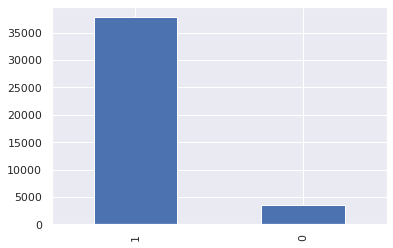

In [ ]:
data["cb"]
data["cb"].value_counts().plot(kind='bar')

## How Many New Banks?
## Distribution of New Banks vs Older Banks?
## How many new banks are community banks?

0    41196
1      193
Name: new_bank, dtype: int64


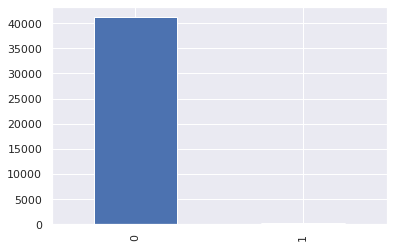

In [ ]:
data["new_bank"].value_counts().plot(kind='bar')
print(data["new_bank"].value_counts())

1    168
0     25
Name: cb, dtype: int64


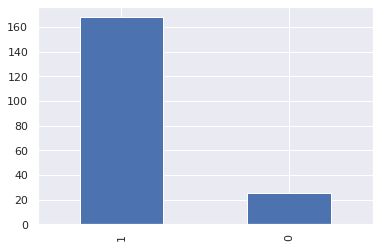

In [ ]:
new_banks = data[data["new_bank"] == 1]
new_banks["cb"].value_counts().plot(kind='bar')
print(new_banks["cb"].value_counts())

## Assets, Liabilities, Deposits of Community Banks vs NonCommunity Banks

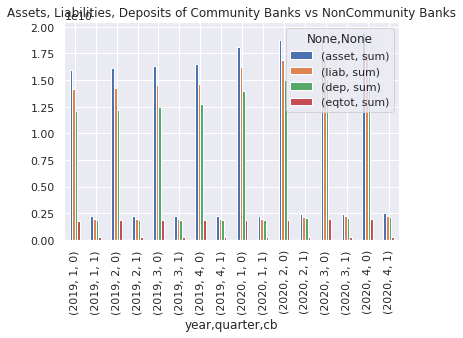

In [ ]:
data.groupby([data['year'], data['quarter'], data['cb']])[['asset', 'liab', 'dep', 'eqtot']].agg(['sum']).plot(kind='bar',
 title = "Assets, Liabilities, Deposits of Community Banks vs NonCommunity Banks",
    legend=True
)

## PPP Distribution of Community Banks vs NonCommunity Banks

In [ ]:
ppp_data = data [ data["year"] == 2020 ]
df.query('a > 0 and 0 < b < 2')
data.groupby([data['year'], data['quarter'], data['cb']])[['ppplnbal']].agg(['sum']).plot(kind='bar',
 title = "PPP Dist of Community Banks vs NonCommunity Banks",
    legend=True
)

NameError: ignored

# Descriptive Statistics

In [ ]:
comm_banks_data = data[data["cb"] == 1]
noncomm_banks_data = data[data["cb"] == 0]

# Number of PPP Loans
print("*** Number of PPP Loans ***")
print("Community banks: mean:{}, median:{}".format(np.log(1+ comm_banks_data["ppplnnum"].dropna()).mean(),np.log(1+ comm_banks_data["ppplnnum"].dropna()).median()))
print("Non-Community banks: mean:{}, median:{}".format(np.log(1+noncomm_banks_data["ppplnnum"]).dropna().mean(),np.log(1+ noncomm_banks_data["ppplnnum"].dropna()).median()))

print("Community banks describe")
print(np.log(1+ comm_banks_data["ppplnnum"].dropna()).describe())

print("Non-Community banks describe")
print(np.log(1+ noncomm_banks_data["ppplnnum"].dropna()).describe())

print(f'ppplnnum describe')
print(np.log(1+data["ppplnnum"].dropna()).describe())
print(np.log(1+data["ppplnnum"].dropna()).median())

model1 = sms.CompareMeans.from_data(np.log(1+comm_banks_data["ppplnnum"].dropna()), np.log(1+noncomm_banks_data["ppplnnum"].dropna()))
print(model1.summary( usevar='pooled'))
print()

data

# Balance of PPP Loans
print("*** Balance of PPP Loans ***")
print("Community banks: mean:{}, median:{}".format(np.log(1+ comm_banks_data["ppplnbal"].dropna()).mean(),np.log(1+ comm_banks_data["ppplnbal"].dropna()).median()))
print("Non-Community banks: mean:{}, median:{}".format(np.log(1+noncomm_banks_data["ppplnbal"]).dropna().mean(),np.log(1+ noncomm_banks_data["ppplnbal"].dropna()).median()))

print("Community banks describe")
print(np.log(1+ comm_banks_data["ppplnbal"].dropna()).describe())

print("Non-Community banks describe")
print(np.log(1+ noncomm_banks_data["ppplnbal"].dropna()).describe())


print(f'ppplnbal describe')
print(np.log(1+data["ppplnbal"].dropna()).describe())

model2 = sms.CompareMeans.from_data(np.log(1+ comm_banks_data["ppplnbal"].dropna()), np.log(1+ noncomm_banks_data["ppplnbal"].dropna()))
print(model2.summary( usevar='pooled'))
print()


# Log Assets
print("*** Log Assets ***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["log_assets"].dropna().mean(),comm_banks_data["log_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["log_assets"].dropna().mean(),noncomm_banks_data["log_assets"].dropna().median()))

print("Community banks describe")
print(comm_banks_data["log_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["log_assets"].dropna().describe())


print(f'Log Assets  describe')
print(data["log_assets"].dropna().describe())

model3 = sms.CompareMeans.from_data(comm_banks_data["log_assets"].dropna(), noncomm_banks_data["log_assets"].dropna())
print(model3.summary( usevar='pooled'))
print()

# Equity to Assets
print("*** Equity to Assets ***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["eq_assets"].dropna().mean(),comm_banks_data["eq_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["eq_assets"].dropna().mean(),noncomm_banks_data["eq_assets"].dropna().median()))

print("Community banks describe")
print(comm_banks_data["eq_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["eq_assets"].dropna().describe())


print(f'Equity to Assets  describe')
print(data["eq_assets"].dropna().describe())

model4 = sms.CompareMeans.from_data(comm_banks_data["eq_assets"].dropna(), noncomm_banks_data["eq_assets"].dropna())
print(model4.summary( usevar='pooled'))
print()

# NonCurrentLoans to Assets
print("*** NonCurrentLoans to Assets ***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["nclnls_assets"].dropna().mean(),comm_banks_data["nclnls_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["nclnls_assets"].dropna().mean(),noncomm_banks_data["nclnls_assets"].dropna().median()))

print("Community banks describe")
print(comm_banks_data["nclnls_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["nclnls_assets"].dropna().describe())


print(f'NonCurrentLoans to Assets describe')
print(data["nclnls_assets"].dropna().describe())


model5 = sms.CompareMeans.from_data(comm_banks_data["nclnls_assets"].dropna(), noncomm_banks_data["nclnls_assets"].dropna())
print(model5.summary( usevar='pooled'))
print()

# ROA
print("*** ROA ***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["roa"].dropna().mean(),comm_banks_data["roa"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["roa"].dropna().mean(),noncomm_banks_data["roa"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["roa"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["roa"].dropna().describe())


print(f'ROA')
print(data["roa"].dropna().describe())

model6 = sms.CompareMeans.from_data(comm_banks_data["roa"].dropna(), noncomm_banks_data["roa"].dropna())
print(model6.summary( usevar='pooled'))
print()


# ROE
print("*** ROE ***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["roe"].dropna().mean(),comm_banks_data["roe"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["roe"].dropna().mean(),noncomm_banks_data["roe"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["roe"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["roe"].dropna().describe())


print(f'ROE')
print(data["roe"].dropna().describe())

model7 = sms.CompareMeans.from_data(comm_banks_data["roe"].dropna(), noncomm_banks_data["roe"].dropna())
print(model7.summary( usevar='pooled'))
print()


# Liquid (Cash Balance)
print("*** Liquid (Cash Balance)***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["chbal_assets"].dropna().mean(),comm_banks_data["chbal_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["chbal_assets"].dropna().mean(),noncomm_banks_data["chbal_assets"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["chbal_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["chbal_assets"].dropna().describe())


print(f'Liquid (Cash Balance)')
print(data["chbal_assets"].dropna().describe())

model8 = sms.CompareMeans.from_data(comm_banks_data["chbal_assets"].dropna(), noncomm_banks_data["chbal_assets"].dropna())
print(model8.summary( usevar='pooled'))
print()

# Deposits
print("*** Deposits***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["dep_assets"].dropna().mean(),comm_banks_data["dep_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["dep_assets"].dropna().mean(),noncomm_banks_data["dep_assets"].dropna().median()))

print("Community banks describe")
print(comm_banks_data["dep_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["dep_assets"].dropna().describe())



print(f'Deposits')
print(data["dep_assets"].dropna().describe())

model9 = sms.CompareMeans.from_data(comm_banks_data["dep_assets"].dropna(), noncomm_banks_data["dep_assets"].dropna())
print(model9.summary( usevar='pooled'))
print()

# New_bank
print("*** New Bank***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["new_bank"].dropna().mean(),comm_banks_data["new_bank"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["new_bank"].dropna().mean(),noncomm_banks_data["new_bank"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["new_bank"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["new_bank"].dropna().describe())


print(f'New Bank')
print(data["new_bank"].dropna().describe())

model10 = sms.CompareMeans.from_data(comm_banks_data["new_bank"].dropna(), noncomm_banks_data["new_bank"].dropna())
print(model10.summary( usevar='pooled'))
print()

# Loans to Commercial and Industrial
print("*** Loans to Commercial and Industrial***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["lnci_assets"].dropna().mean(),comm_banks_data["lnci_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["lnci_assets"].dropna().mean(),noncomm_banks_data["lnci_assets"].dropna().median()))

print("Community banks describe")
print(comm_banks_data["lnci_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["lnci_assets"].dropna().describe())


print(f'Loans to Commercial and Industrial')
print(data["lnci_assets"].dropna().describe())

model11 = sms.CompareMeans.from_data(comm_banks_data["lnci_assets"].dropna(), noncomm_banks_data["lnci_assets"].dropna())
print(model11.summary( usevar='pooled'))
print()

# Assets / Employees
print("*** Assets / Employees***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["astempm"].dropna().mean(),comm_banks_data["astempm"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["astempm"].dropna().mean(),noncomm_banks_data["astempm"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["astempm"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["astempm"].dropna().describe())


print(f'Assets / Employees')
print(data["astempm"].dropna().describe())

model11 = sms.CompareMeans.from_data(comm_banks_data["astempm"].dropna(), noncomm_banks_data["astempm"].dropna())
print(model11.summary( usevar='pooled'))
print()

# Security / Assets
print("*** Security / Assets***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["sc_assets"].dropna().mean(),comm_banks_data["sc_assets"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["sc_assets"].dropna().mean(),noncomm_banks_data["sc_assets"].dropna().median()))

print("Community banks describe")
print(comm_banks_data["sc_assets"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["sc_assets"].dropna().describe())


print(f'Security / Assets')
print(data["sc_assets"].dropna().describe())

model12 = sms.CompareMeans.from_data(comm_banks_data["sc_assets"].dropna(), noncomm_banks_data["sc_assets"].dropna())
print(model12.summary( usevar='pooled'))
print()

# Age
print("***Age***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["age"].dropna().mean(),comm_banks_data["age"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["age"].dropna().mean(),noncomm_banks_data["age"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["age"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["age"].dropna().describe())



print(f'Age')
print(data["age"].dropna().describe())

model13 = sms.CompareMeans.from_data(comm_banks_data["age"].dropna(), noncomm_banks_data["age"].dropna())
print(model13.summary( usevar='pooled'))
print()


# CB
print("***CB***")
print("Community banks: mean:{}, median:{}".format(comm_banks_data["cb"].dropna().mean(),comm_banks_data["cb"].dropna().median()))
print("Non-Community banks: mean:{}, median:{}".format(noncomm_banks_data["cb"].dropna().mean(),noncomm_banks_data["cb"].dropna().median()))


print("Community banks describe")
print(comm_banks_data["cb"].dropna().describe())

print("Non-Community banks describe")
print(noncomm_banks_data["cb"].dropna().describe())



print(f'CB')
print(data["cb"].dropna().describe())

model13 = sms.CompareMeans.from_data(comm_banks_data["cb"].dropna(), noncomm_banks_data["cb"].dropna())
print(model13.summary( usevar='pooled'))
print()

*** Number of PPP Loans ***
Community banks: mean:2.497410258980047, median:0.0
Non-Community banks: mean:3.292258783717221, median:0.0
Community banks describe
count    23374.000000
mean         2.497410
std          2.674344
min          0.000000
25%          0.000000
50%          0.000000
75%          5.075174
max         11.540210
Name: ppplnnum, dtype: float64
Non-Community banks describe
count    2223.000000
mean        3.292259
std         3.907525
min         0.000000
25%         0.000000
50%         0.000000
75%         7.186121
max        12.744870
Name: ppplnnum, dtype: float64
ppplnnum describe
count    25597.000000
mean         2.566440
std          2.811859
min          0.000000
25%          0.000000
50%          0.000000
75%          5.164786
max         12.744870
Name: ppplnnum, dtype: float64
0.0
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/weightstats.py:650: RuntimeWarning: divide by zero encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff


# Ordinary Least Squares and Fixed Effects Analysis

In [ ]:
data.set_index(['year','quarter'], inplace=True)

In [ ]:
exogs_vars = ['astempm','roe','roa','cb','log_assets','eq_assets','nclnls_assets','chbal_assets','new_bank','lnci_assets','dep_assets','sc_assets','age']
exogs = sm.add_constant(data[exogs_vars])

# PPL Loan Originations by Community Banks and Non-Community Banks

print("PPL Loan Originations by Community Banks and Non-Community Banks")

print("*** Number of PPP Loans")
mod1 = PanelOLS(data['log_ppplnnum'], exogs, entity_effects=False,time_effects=False)
panel_res1 = mod1.fit()
print(panel_res1)

print("*** Balance of PPP Loans")
mod2 = PanelOLS(data['log_ppplnbal'], exogs, entity_effects=False,time_effects=False)
panel_res2 = mod2.fit()
print(panel_res2)


PPL Loan Originations by Community Banks and Non-Community Banks
*** Number of PPP Loans


/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:           log_ppplnnum   R-squared:                        0.2406
Estimator:                   PanelOLS   R-squared (Between):             -0.0054
No. Observations:               25525   R-squared (Within):               0.2385
Date:                Sun, Oct 10 2021   R-squared (Overall):              0.2406
Time:                        19:13:04   Log-likelihood                 -5.91e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      621.85
Entities:                           2   P-value                           0.0000
Avg Obs:                    1.276e+04   Distribution:                F(13,25511)
Min Obs:                       5351.0                                           
Max Obs:                    2.017e+04   F-statistic (robust):             621.85
                            